<a href="https://colab.research.google.com/github/Shushant-k1/ML-project/blob/main/Forecasting_Sticker_Sales.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# IMPORTANT: SOME KAGGLE DATA SOURCES ARE PRIVATE
# RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES.
import kagglehub
kagglehub.login()


In [2]:
# IMPORTANT: RUN THIS CELL IN ORDER TO IMPORT YOUR KAGGLE DATA SOURCES,
# THEN FEEL FREE TO DELETE THIS CELL.
# NOTE: THIS NOTEBOOK ENVIRONMENT DIFFERS FROM KAGGLE'S PYTHON
# ENVIRONMENT SO THERE MAY BE MISSING LIBRARIES USED BY YOUR
# NOTEBOOK.

playground_series_s5e1_path = kagglehub.competition_download('playground-series-s5e1')

print('Data source import complete.')


Data source import complete.


In [3]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All"
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [4]:
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings('ignore')
from xgboost import XGBRegressor
import xgboost as xgb
from sklearn.metrics import mean_squared_error


In [5]:
!pip install fancyimpute
! pip install --upgrade xgboost
! pip install miceforest

In [6]:
cd /root/.cache/kagglehub/competitions/playground-series-s5e1

/root/.cache/kagglehub/competitions/playground-series-s5e1


In [7]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')

In [8]:
train.head()

,id,date,country,store,product,num_sold
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0


In [9]:
train.isnull().sum()

,0
id,0
date,0
country,0
store,0
product,0
num_sold,8871


In [10]:
train.shape

(230130, 6)

In [11]:
for col in train.columns :
    x = len(train[col].unique())
    if x < 50 :
        print(col , train[col].value_counts())

country country
Canada       38355
Finland      38355
Italy        38355
Kenya        38355
Norway       38355
Singapore    38355
Name: count, dtype: int64
store store
Discount Stickers       76710
Stickers for Less       76710
Premium Sticker Mart    76710
Name: count, dtype: int64
product product
Holographic Goose     46026
Kaggle                46026
Kaggle Tiers          46026
Kerneler              46026
Kerneler Dark Mode    46026
Name: count, dtype: int64


In [12]:
def transform_date(df, col):
    df[col] = pd.to_datetime(df[col])

    df['year'] = df[col].dt.year.astype('int')
    df['quarter'] = df[col].dt.quarter.astype('int')
    df['month'] = df[col].dt.month.astype('int')
    df['day'] = df[col].dt.day.astype('int')
    df['day_of_week'] = df[col].dt.dayofweek.astype('int')
    df['week_of_year'] = df[col].dt.isocalendar().week.astype('int')

    df['day_sin'] = np.sin(2 * np.pi * df['day'] / 365)
    df['day_cos'] = np.cos(2 * np.pi * df['day'] / 365)
    df['month_sin'] = np.sin(2 * np.pi * df['month'] / 12)
    df['month_cos'] = np.cos(2 * np.pi * df['month'] / 12)
    df['year_sin'] = np.sin(2 * np.pi * df['year'] / 7)
    df['year_cos'] = np.cos(2 * np.pi * df['year'] / 7)

    df['group'] = (df['year'] - 2010) * 48 + df['month'] * 4 + df['day'] // 7

    return df


In [13]:
train = transform_date(train, 'date')
test = transform_date(test, 'date')


In [14]:
train.head()

,id,date,country,store,product,num_sold,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,0,2010-01-01,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,1,2010-01-01,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,2,2010-01-01,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,3,2010-01-01,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,4,2010-01-01,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [15]:
train = train.drop(columns=['date'], axis=1)
test = test.drop(columns=['date'], axis=1)

In [16]:
train.head()

,id,country,store,product,num_sold,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,0,Canada,Discount Stickers,Holographic Goose,NaN,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,1,Canada,Discount Stickers,Kaggle,973.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,2,Canada,Discount Stickers,Kaggle Tiers,906.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,3,Canada,Discount Stickers,Kerneler,423.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,4,Canada,Discount Stickers,Kerneler Dark Mode,491.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [17]:
from sklearn.preprocessing import LabelEncoder

def label_encoder(data_frame):
    cat_cols = ['country', 'store', 'product']
    label_encoders = {}

    for col in cat_cols:
        le = LabelEncoder()
        data_frame[col] = le.fit_transform(data_frame[col])
        label_encoders[col] = le

    return data_frame

test = label_encoder(test)
train = label_encoder(train)


In [18]:
test

,id,country,store,product,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,230130,0,0,0,2017,1,1,1,6,52,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490,340
1,230131,0,0,1,2017,1,1,1,6,52,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490,340
2,230132,0,0,2,2017,1,1,1,6,52,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490,340
3,230133,0,0,3,2017,1,1,1,6,52,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490,340
4,230134,0,0,4,2017,1,1,1,6,52,0.017213,0.999852,5.000000e-01,0.866025,0.781831,0.623490,340
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
98545,328675,5,1,0,2019,4,12,31,1,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969,484
98546,328676,5,1,1,2019,4,12,31,1,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969,484
98547,328677,5,1,2,2019,4,12,31,1,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969,484
98548,328678,5,1,3,2019,4,12,31,1,1,0.508671,0.860961,-2.449294e-16,1.000000,0.433884,-0.900969,484


In [19]:
mean_value = train["num_sold"].mean()
mean_imputation=train["num_sold"].fillna(mean_value)

median_value = train["num_sold"].median()
median_imputation = train["num_sold"].fillna(median_value)

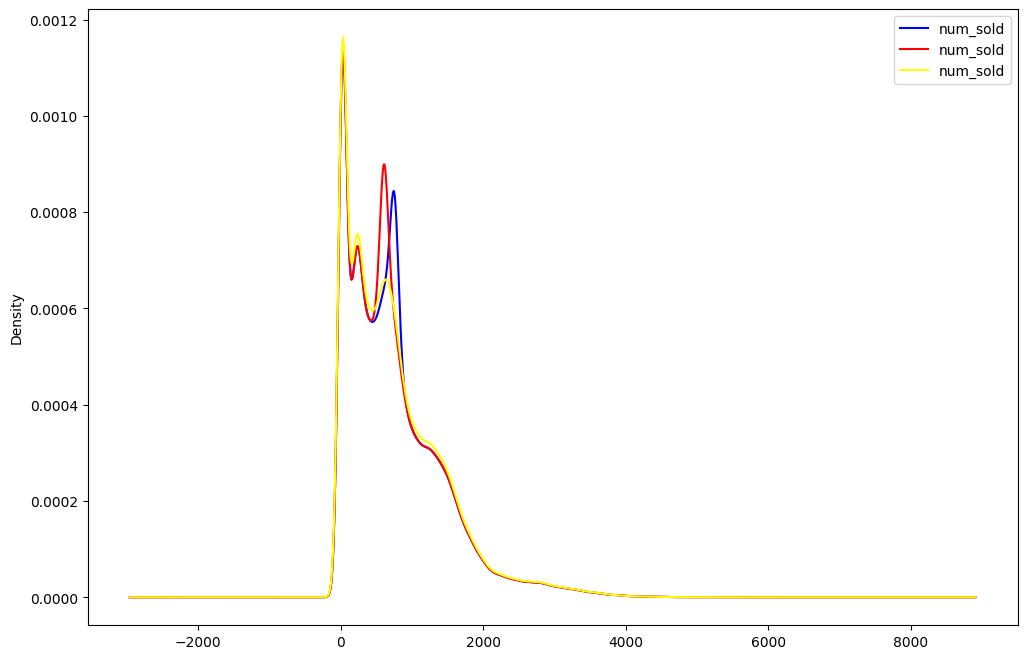

In [20]:
plt.figure(figsize=(12,8))

mean_imputation.plot(kind="kde" , color="blue")
median_imputation.plot(kind="kde" , color ="red")
train["num_sold"].plot(kind="kde" , color ="yellow")
plt.legend()
plt.show()

In [21]:

train.head()

,id,country,store,product,num_sold,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,0,0,0,0,NaN,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,1,0,0,1,973.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,2,0,0,2,906.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,3,0,0,3,423.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,4,0,0,4,491.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


In [22]:
from miceforest import ImputationKernel

In [23]:
mice_kernel = ImputationKernel(data = train,random_state = 2023)

In [24]:
mice_kernel.mice(2)
mice_imputation = mice_kernel.complete_data()
mice_imputation.head()

,id,country,store,product,num_sold,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group
0,0,0,0,0,130.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
1,1,0,0,1,973.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
2,2,0,0,2,906.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
3,3,0,0,3,423.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4
4,4,0,0,4,491.0,2010,1,1,1,4,53,0.017213,0.999852,0.5,0.866025,0.781831,0.62349,4


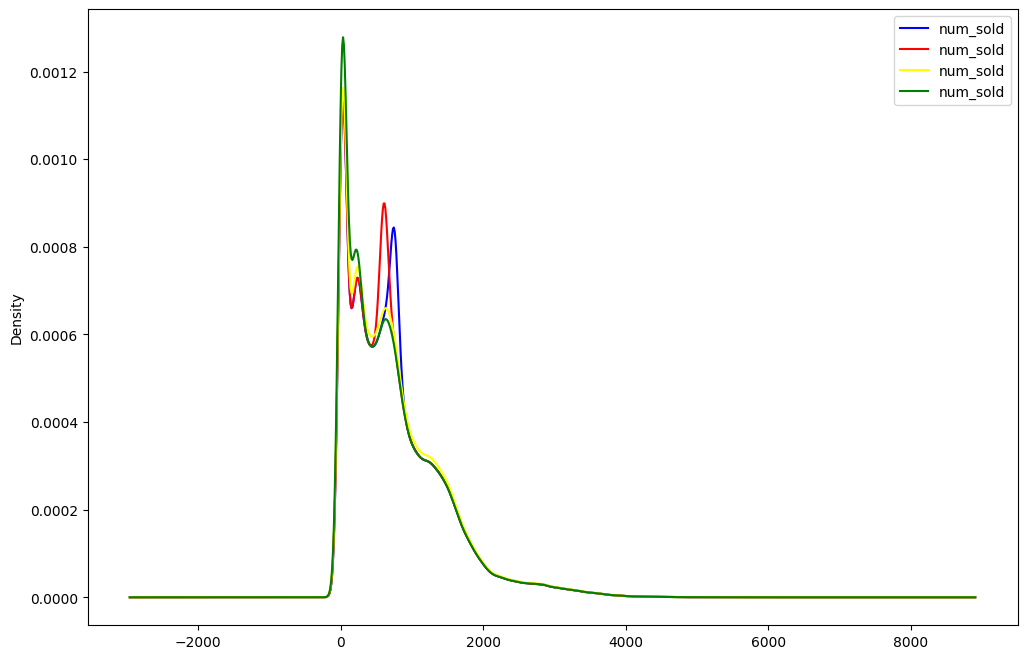

In [25]:
plt.figure(figsize=(12,8))

mean_imputation.plot(kind="kde" , color="blue")
median_imputation.plot(kind="kde" , color ="red")
train["num_sold"].plot(kind="kde" , color ="yellow") # mice (yellow)
mice_imputation["num_sold"].plot(kind="kde" , color="green") #original (green)
plt.legend()
plt.show()


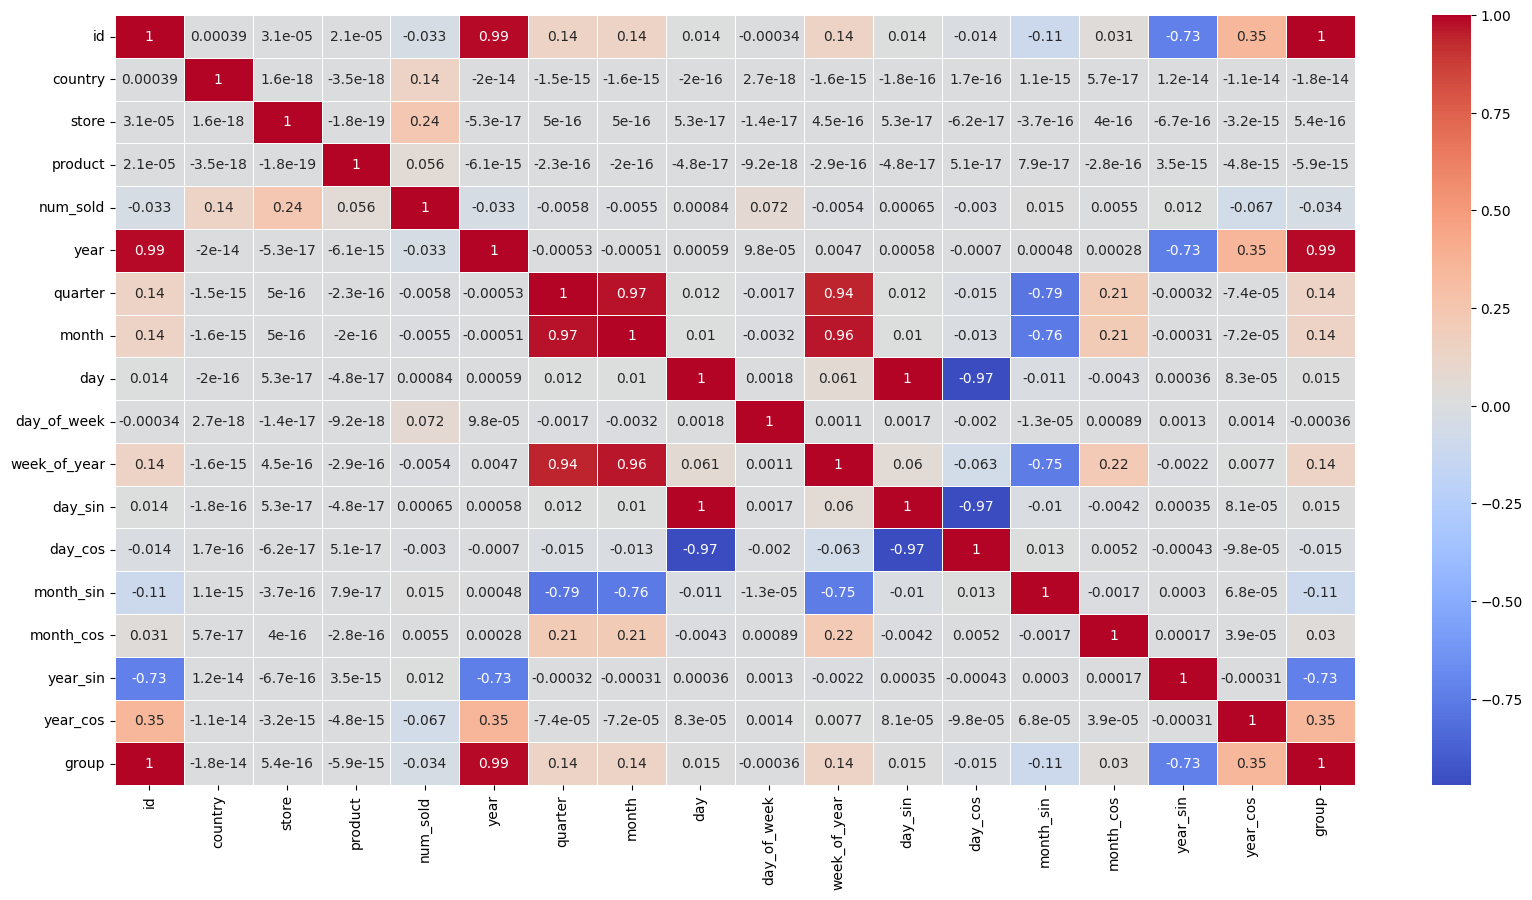

In [26]:
# Set figure size
plt.figure(figsize=(20 , 10))

# Plot the correlation heatmap with the 'coolwarm' colormap
sns.heatmap(mice_imputation.corr(), cmap='coolwarm', annot=True, linewidths=0.5)

# Show the plot
plt.show()

In [27]:
import numpy as np

# Apply logarithmic transformation to the 'num_sold' column
# We use np.log1p to handle cases where the column may contain zeros
mice_imputation['num_sold_log'] = np.log1p(mice_imputation['num_sold'])

# Display the updated DataFrame
print(mice_imputation[['num_sold', 'num_sold_log']].head())


   num_sold  num_sold_log
0     130.0      4.875197
1     973.0      6.881411
2     906.0      6.810142
3     423.0      6.049733
4     491.0      6.198479


In [28]:
mice_imputation.drop('num_sold' , inplace = True , axis = 1)

In [29]:
(mice_imputation.corr())

,id,country,store,product,year,quarter,month,day,day_of_week,week_of_year,day_sin,day_cos,month_sin,month_cos,year_sin,year_cos,group,num_sold_log
id,1.000000,3.856133e-04,3.072641e-05,2.128788e-05,9.897432e-01,1.377965e-01,1.418502e-01,1.395128e-02,-3.383404e-04,1.425302e-01,1.390462e-02,-1.403813e-02,-1.079734e-01,3.050514e-02,-7.263841e-01,3.504865e-01,9.999947e-01,-0.002388
country,0.000386,1.000000e+00,1.619143e-18,-3.526719e-18,-2.015417e-14,-1.469228e-15,-1.558288e-15,-1.953865e-16,2.695292e-18,-1.567770e-15,-1.834967e-16,1.677961e-16,1.105703e-15,5.677618e-17,1.186585e-14,-1.147721e-14,-1.818573e-14,-0.023427
store,0.000031,1.619143e-18,1.000000e+00,-1.771467e-19,-5.282222e-17,4.992294e-16,5.008921e-16,5.332172e-17,-1.415726e-17,4.484853e-16,5.344176e-17,-6.166454e-17,-3.652065e-16,3.954250e-16,-6.722542e-16,-3.230642e-15,5.421025e-16,0.163192
product,0.000021,-3.526719e-18,-1.771467e-19,1.000000e+00,-6.142533e-15,-2.315583e-16,-2.030047e-16,-4.756021e-17,-9.173694e-18,-2.917981e-16,-4.764396e-17,5.063156e-17,7.868600e-17,-2.846563e-16,3.546050e-15,-4.848660e-15,-5.949405e-15,0.136527
year,0.989743,-2.015417e-14,-5.282222e-17,-6.142533e-15,1.000000e+00,-5.280110e-04,-5.127824e-04,5.895938e-04,9.754620e-05,4.734900e-03,5.780292e-04,-7.025836e-04,4.824371e-04,2.770923e-04,-7.338684e-01,3.542086e-01,9.897244e-01,-0.002217
quarter,0.137797,-1.469228e-15,4.992294e-16,-2.315583e-16,-5.280110e-04,1.000000e+00,9.713970e-01,1.204444e-02,-1.667537e-03,9.408215e-01,1.176011e-02,-1.476612e-02,-7.852726e-01,2.144455e-01,-3.241244e-04,-7.393232e-05,1.377974e-01,-0.001584
month,0.141850,-1.558288e-15,5.008921e-16,-2.030047e-16,-5.127824e-04,9.713970e-01,1.000000e+00,1.032695e-02,-3.207736e-03,9.639817e-01,1.009060e-02,-1.259770e-02,-7.609924e-01,2.089447e-01,-3.147762e-04,-7.180000e-05,1.418579e-01,-0.001432
day,0.013951,-1.953865e-16,5.332172e-17,-4.756021e-17,5.895938e-04,1.204444e-02,1.032695e-02,1.000000e+00,1.751276e-03,6.057929e-02,9.998150e-01,-9.712954e-01,-1.062574e-02,-4.315405e-03,3.619276e-04,8.255517e-05,1.506865e-02,0.000039
day_of_week,-0.000338,2.695292e-18,-1.415726e-17,-9.173694e-18,9.754620e-05,-1.667537e-03,-3.207736e-03,1.751276e-03,1.000000e+00,1.067381e-03,1.717716e-03,-1.993421e-03,-1.332275e-05,8.939021e-04,1.265436e-03,1.438522e-03,-3.626685e-04,0.040322
week_of_year,0.142530,-1.567770e-15,4.484853e-16,-2.917981e-16,4.734900e-03,9.408215e-01,9.639817e-01,6.057929e-02,1.067381e-03,1.000000e+00,6.034591e-02,-6.268404e-02,-7.504010e-01,2.152081e-01,-2.190938e-03,7.653179e-03,1.425993e-01,-0.001323


In [30]:
# col_to_keep = []
# for row in mice_imputation['num_sold_log'] :
#     if abs(row)

In [31]:
test.drop('id' , inplace = True , axis = 1)
mice_imputation.drop('id' , inplace = True , axis = 1)


In [32]:
test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 98550 entries, 0 to 98549
Data columns (total 16 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   country       98550 non-null  int64  
 1   store         98550 non-null  int64  
 2   product       98550 non-null  int64  
 3   year          98550 non-null  int64  
 4   quarter       98550 non-null  int64  
 5   month         98550 non-null  int64  
 6   day           98550 non-null  int64  
 7   day_of_week   98550 non-null  int64  
 8   week_of_year  98550 non-null  int64  
 9   day_sin       98550 non-null  float64
 10  day_cos       98550 non-null  float64
 11  month_sin     98550 non-null  float64
 12  month_cos     98550 non-null  float64
 13  year_sin      98550 non-null  float64
 14  year_cos      98550 non-null  float64
 15  group         98550 non-null  int64  
dtypes: float64(6), int64(10)
memory usage: 12.0 MB


In [33]:
# Split the dataset into features (X) and target (y)
X = mice_imputation.drop('num_sold_log', axis=1)  # Features (all columns except 'num_sold_log')
y = mice_imputation['num_sold_log']  # Target (the 'num_sold_log' column)

# You can then split the data into training and test sets
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

# Check the shapes of the datasets
print(f"X_train shape: {X_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"y_test shape: {y_test.shape}")


X_train shape: (161091, 16)
X_test shape: (69039, 16)
y_train shape: (161091,)
y_test shape: (69039,)


In [ ]:
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVR

linear_model = LinearRegression()
linear_model.fit(X_train, y_train)

# svr_model = SVR(kernel='rbf')
# svr_model.fit(X_train, y_train)


In [ ]:
y_train_pred =  linear_model.predict(X_train)
rmse_xg = np.sqrt(mean_squared_error(y_train, linear_model.predict(X_train)))
rmse_xg

In [ ]:
y_test_pred = linear_model.predict(X_test)
rmse_xg_test = np.sqrt(mean_squared_error(y_test, linear_model.predict(X_test)))
rmse_xg_test

In [ ]:
y_test_pred = model.predict(test)


In [ ]:
ids = pd.Series(range(230130, 230130 + len(y_test_pred)), name="id")

# Create a DataFrame with the predictions
predictions = pd.DataFrame(y_test_pred, columns=['Prediction'])

# Combine the IDs and predictions into a single DataFrame
submission_df = pd.concat([ids, predictions], axis=1)

# Save the result to a CSV file for Kaggle submission
submission_df.to_csv('kaggle_submission.csv', index=False)

# Check the first few rows of the submission file
print(submission_df.head())

In [ ]:
sample = pd.read_csv('/kaggle/input/playground-series-s5e1/sample_submission.csv')

In [ ]:
ls